# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.setting import load_setting
from funcs.tide import get_date_str_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260105.xlsx"
code = "7011"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
date_str = get_date_str_from_file(excel)

app = Disciple(excel, code, dict_setting)
app.run()

パラメータ
PERIOD_MA_1 : 60
PERIOD_MA_2 : 600
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.1
LOSSCUT_1 : -25


In [3]:
# 取引明細
df_transaction = app.getTransaction()
print("取引明細")
print(df_transaction)
list_trans = [pd.to_datetime(t) for t in df_transaction["注文日時"]]
# print(list_trans)
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
   注文番号                 注文日時 銘柄コード  売買  約定単価 約定数量    損益 備考
0     1  2026-01-05 09:07:12  7011  売建  4033  100   NaN   
1     2  2026-01-05 09:07:24  7011  買埋  4028  100   500   
2     3  2026-01-05 09:07:25  7011  買建  4028  100   NaN   
3     4  2026-01-05 09:26:18  7011  売埋  4085  100  5700   
4     5  2026-01-05 09:26:19  7011  売建  4085  100   NaN   
5     6  2026-01-05 09:26:41  7011  買埋  4087  100  -200   
6     7  2026-01-05 09:59:21  7011  買建  4176  100   NaN   
7     8  2026-01-05 10:00:23  7011  売埋  4172  100  -400   
8     9  2026-01-05 10:02:30  7011  買建  4181  100   NaN   
9    10  2026-01-05 10:11:23  7011  売埋  4177  100  -400   
10   11  2026-01-05 10:22:58  7011  買建  4168  100   NaN   
11   12  2026-01-05 10:26:53  7011  売埋  4161  100  -700   
12   13  2026-01-05 10:30:43  7011  買建  4168  100   NaN   
13   14  2026-01-05 10:37:27  7011  売埋  4167  100  -100   
14   15  2026-01-05 12:57:01  7011  買建  4162  100   NaN   
15   16  2026-01-05 13:10:56  7011  売埋  4168  100  

In [4]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts          ma1          ma2    slope1  profit  \
2026-01-05 09:06:04  1.767572e+09  4001.000000  4001.000000  0.000000     0.0   
2026-01-05 09:06:05  1.767572e+09  4001.000000  4001.000000  0.000000     0.0   
2026-01-05 09:06:06  1.767572e+09  4006.333333  4006.333333  1.777778     0.0   
2026-01-05 09:06:07  1.767572e+09  4009.000000  4009.000000  2.000000     0.0   
2026-01-05 09:06:08  1.767572e+09  4011.200000  4011.200000  2.040000     0.0   
...                           ...          ...          ...       ...     ...   
2026-01-05 15:24:45  1.767594e+09  4177.116667  4182.910000  0.156667     0.0   
2026-01-05 15:24:46  1.767594e+09  4176.966667  4182.881667  0.156667     0.0   
2026-01-05 15:24:47  1.767594e+09  4176.800000  4182.853333  0.160000     0.0   
2026-01-05 15:24:48  1.767594e+09  4176.633333  4182.826667  0.160000     0.0   
2026-01-05 15:24:49  1.767594e+09  4176.483333  4182.800000  0.156667     0.0   

                   

In [5]:
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

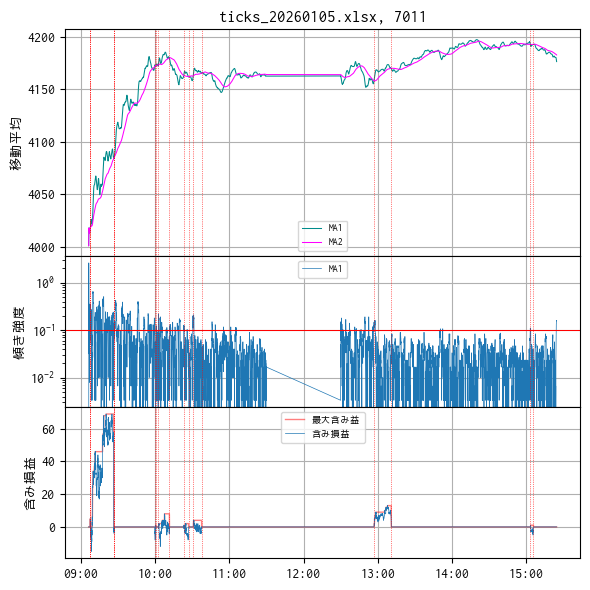

In [9]:
fig = plt.figure(figsize=(6, 6))
n = 3
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1.5 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["ma1"], linewidth=0.75, color="darkcyan", label="MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.75)
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)

ax[2].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[2].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[2].set_ylabel("含み損益")
ax[2].legend(fontsize=7)

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join("tmp", f"{date_str}_trend_technical.png")
plt.tight_layout()
plt.savefig(output)
plt.show()

In [10]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  ロス1   建玉
2026-01-05 09:06:04    0.0    0.0  0.0  0.0  0.0
2026-01-05 09:06:05    0.0    0.0  0.0  0.0  0.0
2026-01-05 09:06:06    0.0    0.0  0.0  0.0  0.0
2026-01-05 09:06:07    0.0    0.0  0.0  0.0  0.0
2026-01-05 09:06:08    0.0    0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...
2026-01-05 15:24:45    0.0    0.0  0.0  0.0  0.0
2026-01-05 15:24:46    0.0    0.0  0.0  0.0  0.0
2026-01-05 15:24:47    0.0    0.0  0.0  0.0  0.0
2026-01-05 15:24:48    0.0    0.0  0.0  0.0  0.0
2026-01-05 15:24:49    0.0    0.0  0.0  0.0  0.0

[19068 rows x 5 columns]


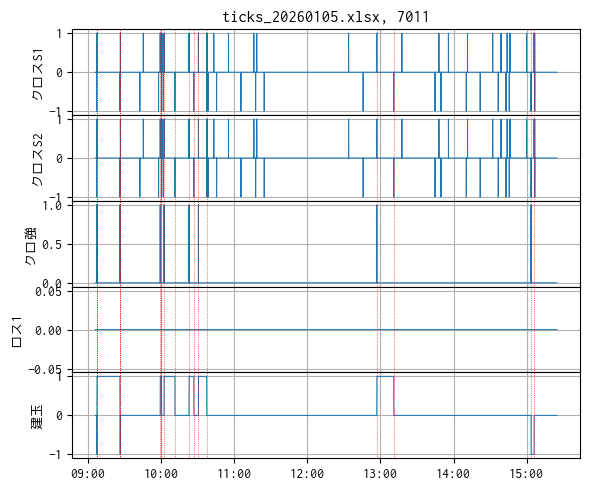

In [11]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)])
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].set_title(f"{excel}, {code}")

for i, colname in enumerate(df_obs.columns):
    ax[i].plot(df_obs[colname], linewidth=0.75)
    ax[i].set_ylabel(colname)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join("tmp", f"{date_str}_trend_obs.png")
plt.tight_layout()
plt.savefig(output)
plt.show()